# Galactic binary and superradiance data analysis

## 0 Imports

In [19]:
import ldc.waveform.fastGB as FB
from ldc.lisa import orbits
from astropy import units as un
import numpy as np
#from memory_profiler import profile
import fastGB as FB_MLDC
import matplotlib.pyplot as plt
import math
from scipy.special import gamma,gammainc,gammaincc
import scipy.integrate as integr
import spritz

from spritz import utils, inference, masking, waveforms, sampling
from ldc.lisa import orbits
from ldc.lisa.noise import get_noise_model

import matplotlib.pyplot as plt
from ldc.lisa.orbits import Orbits
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
import ldc.io.yml as ymlio
import os
import h5py
import ldc.waveform.fastGB as FB
from ldc.common.series import TimeSeries
from ldc.common import constants
plt.rcParams['text.usetex']=True

## 1 Generate GW signal

In [20]:
#SourceParameters
bet=np.arcsin(0.12559907)
long=0.71733837
i=np.arccos(0.70144304)
tab_Param=(1.43327232e-22,  0.12593166, long,0.00774, 2.3961e-21, 0.79337616, 0.41646956,4.91653383)

In [22]:
Tobs = 365*24*60*60*0.5
dt = 15.0

config = {"dt":dt, "initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic', 
          "t_max": Tobs, "t_min": 0, "travel_time_order": 1}


cat = np.array([tab_Param],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

In [23]:
# Set orbit model
lisa_orbits = orbits.Orbits.type(dict({"nominal_arm_length":2.5e6*un.km,
                                    "initial_rotation":0*un.rad,
                                    "initial_position":0*un.rad,
                                    "orbit_type":"analytic"}))

In [24]:
GB = FB.FastGB(delta_t=dt, T=Tobs, orbits=lisa_orbits)
pGB = dict(zip(cat.dtype.names, cat[0]))

In [25]:
X2_t,Y2_t,Z2_t=GB.get_td_tdixyz(template=pGB,oversample=4,tdi2=True)
N = len(X2_t)

Text(0, 0.5, 'Amplitude')

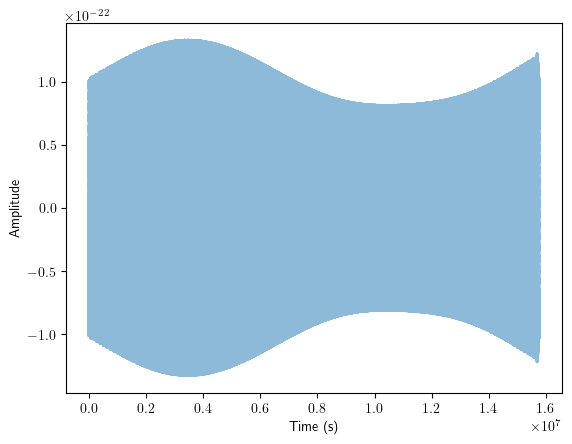

In [26]:
plt.plot(X2_t.t, X2_t, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [27]:
def XYZ2AET(X, Y, Z):
    A,E,T = ((Z - X)/np.sqrt(2.0),
            (X - 2.0*Y + Z)/np.sqrt(6.0),
            (X + Y + Z)/np.sqrt(3.0))
    if hasattr(X, "attrs"):
        A.attrs = X.attrs
    return A,E,T

In [28]:
# Get AET from XYZ (devide by dt to have the units of strain only)
A_t, E_t, T_t = XYZ2AET(X2_t, Y2_t, Z2_t)
aet_signal = np.asarray([channel.to_numpy() for channel in [A_t, E_t, T_t]]).T

Text(0, 0.5, 'Amplitude')

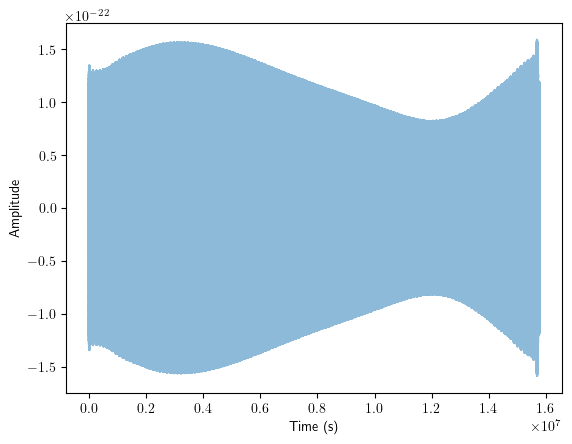

In [29]:
plt.plot(X2_t.t, aet_signal[:, 0], alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

## 2 Generate noise

In [30]:
import backgroundsmaster
from backgroundsmaster.backgrounds.utils import generate_noise
#from backgrounds.utils import generate_noise

In [31]:
f_tot=np.fft.fftfreq(N)/dt
noise_model = get_noise_model('SciRDv1', f_tot[f_tot>0], wd=False)

In [32]:
# noise PSDs
def psd_a(freq):
    return noise_model.psd(freq=freq, option='A', tdi2=True)
def psd_t(freq):
    return noise_model.psd(freq=freq, option='T', tdi2=True)

f_sampling = 1/dt
a_noise = generate_noise(psd_func=psd_a, n_data=N, fs=f_sampling)
e_noise = generate_noise(psd_func=psd_a, n_data=N, fs=f_sampling)
t_noise = generate_noise(psd_func=psd_t, n_data=N, fs=f_sampling)
aet_noise = np.asarray([a_noise, e_noise, t_noise]).T

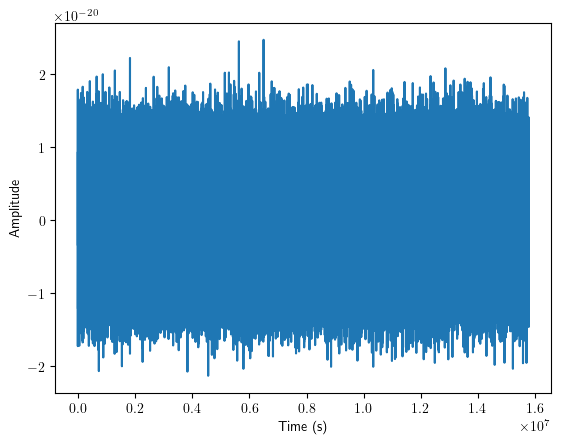

In [33]:
t = np.linspace(0,Tobs,N)
plt.plot(t, aet_noise[:, 0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## 3. Compare noise and signal in the frequency domain

In [34]:
aet_noise_f = np.fft.fft(aet_noise, axis=0)*dt
aet_signal_f = np.fft.fft(aet_signal, axis=0)*dt

Text(0, 0.5, 'Amplitude')

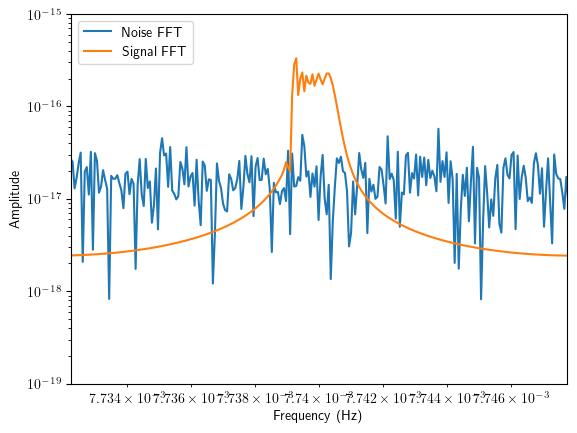

In [36]:
# Fourier transform
plt.figure(0)
plt.loglog(f_tot[f_tot>0], np.abs(aet_noise_f[f_tot>0, 0]), 
           label="Noise FFT")
plt.loglog(f_tot[f_tot>0], np.abs(aet_signal_f[f_tot>0, 0]), 
           label="Signal FFT")
# plt.xlim([0.00715, 0.00765])
plt.legend(loc="upper left")
plt.xlim([tab_Param[3]*(1-0.001), tab_Param[3]*(1+0.001)])
plt.ylim([1e-19, 1e-15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

In [37]:
X2_f, Y2_f, Z2_f = GB.get_fd_tdixyz(template=pGB, tdi2=True)
A_f, E_f, Z_f = XYZ2AET(X2_f, Y2_f, Z2_f)

In [38]:
#Definition of the frequency window 
f0 = tab_Param[3]
p1 = np.argmin(np.abs(X2_f.f.to_numpy()[0]-f_tot))
#p1 = np.argmin(np.abs(X2_f.f.to_numpy()[10]-f_tot))
p2 = np.argmin(np.abs(X2_f.f.to_numpy()[-1]-f_tot))

In [39]:
ids=np.arange(p1, p2+1)
print(len(ids))
print(len(X2_f.f))

64
64


In [40]:
# d_t = aet_signal + aet_noise
aet_data_f = aet_signal_f + aet_noise_f
d = aet_data_f[ids]

## 4. Compare waveforms from data and generator

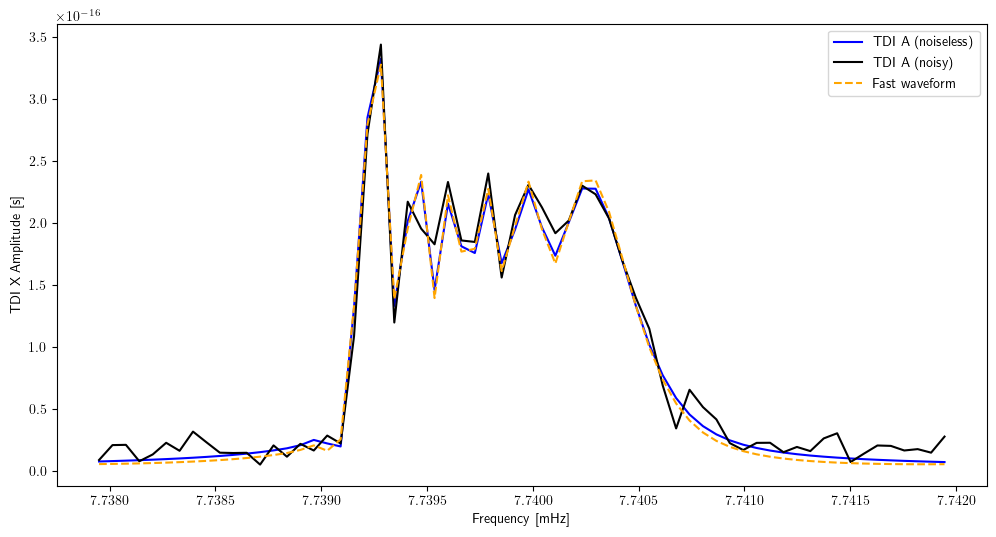

In [41]:
plt.figure(figsize=(12,6))
plt.subplot(111)
plt.plot(f_tot[ids]*1e3,
         np.abs(aet_signal_f[ids, 0]),
         label="TDI A (noiseless)",
         color="blue")
plt.plot(f_tot[ids]* 1e3, np.abs(d[:, 0]),
         label="TDI A (noisy)",
         color='black')
plt.plot(X2_f.f*1e3, np.abs(A_f),
         label="Fast waveform",
         color="orange",
         linestyle='dashed')
plt.legend(loc="upper right")
plt.xlabel("Frequency [mHz]")
plt.ylabel("TDI X Amplitude [s]")
# plt.xlim([7.715,7.765])
# plt.ylim([-0.05e-16,2.5e-16])
plt.show()

In [42]:
# Set waveform model
my_gb = waveforms.MyFastGB(delta_t=dt, T=Tobs, orbits=lisa_orbits) # in seconds

In [43]:
# Set noise model
wd = False
noise_model = get_noise_model('SciRDv1', f_tot[f_tot>0], wd=wd)

In [44]:
# Set likelihood
wd = np.ones(N)
a_data = aet_data_f[:, 0]
e_data = aet_data_f[:, 1]
loglike_cls = inference.GBLikelihood(f_tot, [a_data, e_data], 
                                     noise_model=noise_model, 
                                     signal_model=my_gb,
                                     wd=wd)

In [45]:
X2_f, Y2_f, Z2_f = my_gb.get_fd_tdixyz(template=pGB, tdi2=True)
A_f, E_f, Z_f = XYZ2AET(X2_f, Y2_f, Z2_f)

In [46]:
# There is some ambiguity in the choice of beta and lambda
p_sample_true_0 = utils.waveform2sample(pGB)
# p_sample_true = np.copy(p_sample_true_0)
# p_sample_true[4] = p_sample_true[4] + np.pi
p_sample_true = p_sample_true_0[:]

In [47]:
fr, kmin, signal_ae = loglike_cls.compute_waveform(p_sample_true)

In [48]:
print(type(signal_ae[0]))
print(type(fr))
signal_a = signal_ae[0].to_numpy()
fr_a = fr.to_numpy()

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


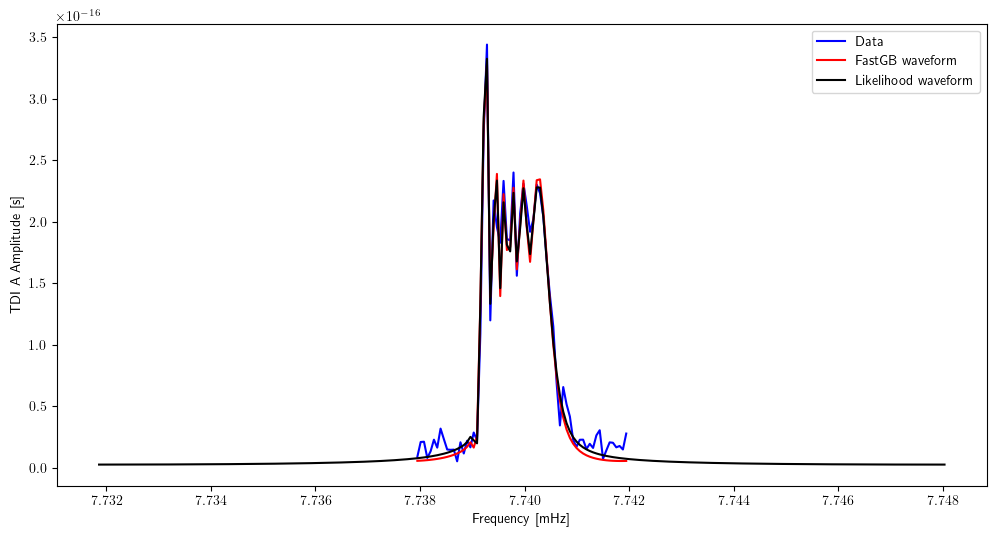

In [49]:
plt.figure(figsize=(12,6))
plt.subplot(111)
plt.plot(f_tot[ids]*1e3,
         np.abs(aet_data_f[ids, 0]),
         label="Data",
         color="blue")
plt.plot(A_f.f * 1e3, np.abs(A_f),
         label="FastGB waveform",
         color='red')
plt.plot(fr_a * 1e3, np.abs(signal_a),
         label="Likelihood waveform",
         color='black')
plt.legend(loc="upper right")
plt.xlabel("Frequency [mHz]")
plt.ylabel("TDI A Amplitude [s]")
# plt.xlim([7.715,7.765])
# plt.ylim([-0.05e-16,2.5e-16])
plt.show()

In [50]:
# Lower bounds
a = np.array([p_sample_true[0] - 1, p_sample_true[1] - 1e-3, -21.5, -1.0, -np.pi, -1.0, 0.0, 0.0])
# Upper bounds
b = np.array([p_sample_true[0] + 1, p_sample_true[1] + 1e-3, -19.5, 1.0, np.pi, 1.0, 2.0*np.pi, 2.0*np.pi])

In [51]:
def shift_param(theta_ref, ip, dp):
    theta_shifted = np.copy(theta_ref)
    theta_shifted[ip] += dp
    return theta_shifted

In [52]:
print(p_sample_true)

[-21.84367129   7.74       -20.62049506   0.12559907   0.71733837
   0.70144304   4.91653383   0.41646956]


In [53]:
param_names = [r"$\log_{10}(A)$", 
               r"$f_0$", 
               r"$\log_{10}(\dot{f}_0)$", 
               r"$\sin \beta$", 
               r"$\lambda$", 
               r"$\cos\i$", 
               r"$\Psi$", 
               r"$\phi_0$"]
j_param = 0
var_max = 1
dlog_amp = np.arange(-var_max, var_max, 0.05)
p_values = [shift_param(p_sample_true, j_param, dl) for dl in dlog_amp]
ll_values = np.array([loglike_cls.evaluate(p) for p in p_values])
i_max = np.argmax(ll_values)

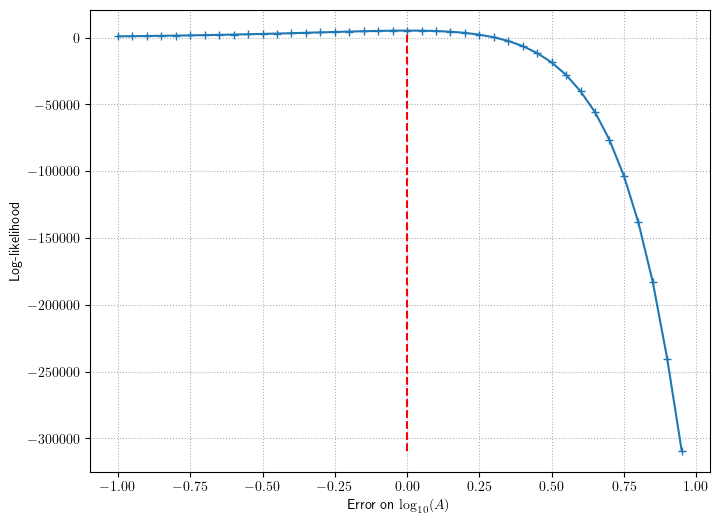

In [54]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(dlog_amp, ll_values, marker='+')
# ax.legend(loc='upper left')
ax.vlines(dlog_amp[i_max], np.min(ll_values), 
          ll_values[i_max], color='red', linestyle='dashed')
# ax.set_xlabel(r"$\log (\Omega / 10^{-14})$")
ax.set_xlabel(r"Error on " + param_names[j_param])
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

In [55]:
j_param = 1
dlog_f = np.linspace(a[j_param], b[j_param], 1000) - p_sample_true[j_param]
p_values = [shift_param(p_sample_true, j_param, dl) for dl in dlog_f]
ll_values = np.array([loglike_cls.evaluate(p) for p in p_values])
i_max = np.argmax(ll_values)

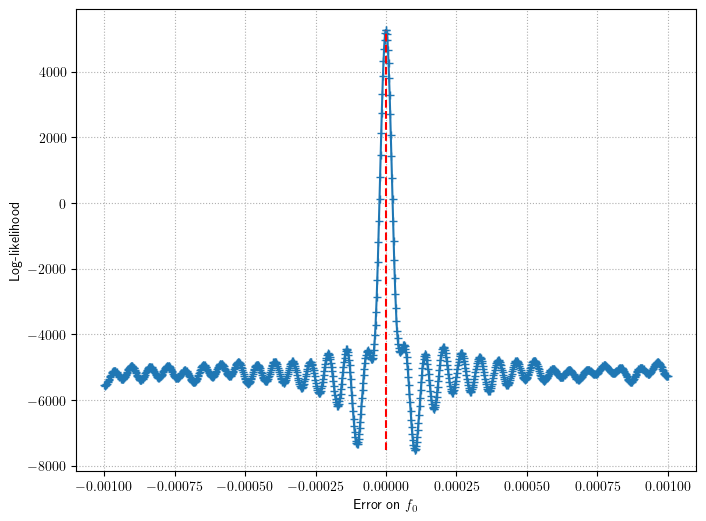

In [56]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(dlog_f, ll_values, marker='+')
# ax.legend(loc='upper left')
ax.vlines(dlog_f[i_max], np.min(ll_values), 
          ll_values[i_max], color='red', linestyle='dashed')
# ax.set_xlabel(r"$\log (\Omega / 10^{-14})$")
ax.set_xlabel(r"Error on " + param_names[j_param])
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

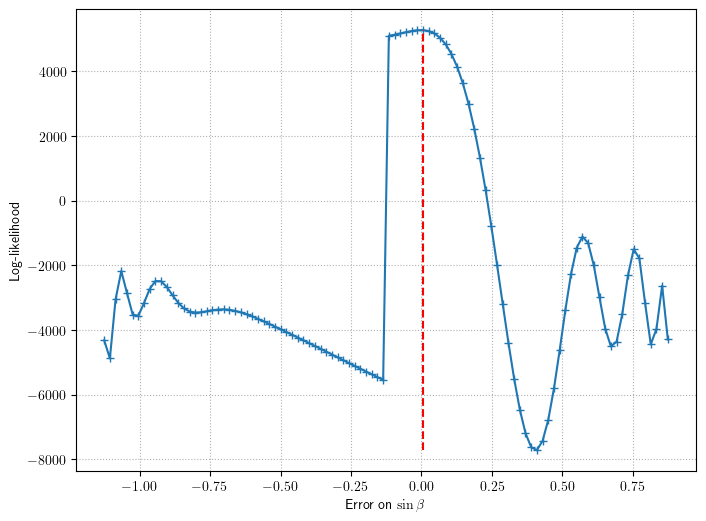

In [57]:
j_param = 3
dlog_f = np.linspace(a[j_param], b[j_param], 100) - p_sample_true[j_param]
p_values = [shift_param(p_sample_true, j_param, dl) for dl in dlog_f]
ll_values = np.array([loglike_cls.evaluate(p) for p in p_values])
i_max = np.argmax(ll_values)


fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(dlog_f, ll_values, marker='+')
# ax.legend(loc='upper left')
ax.vlines(dlog_f[i_max], np.min(ll_values), 
          ll_values[i_max], color='red', linestyle='dashed')
# ax.set_xlabel(r"$\log (\Omega / 10^{-14})$")
ax.set_xlabel(r"Error on " + param_names[j_param])
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

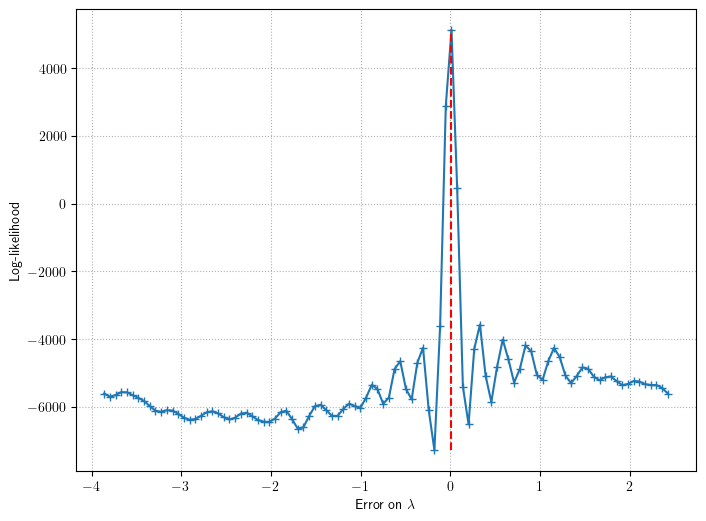

In [58]:
j_param = 4
dlog_f = np.linspace(a[j_param], b[j_param], 100) - p_sample_true[j_param]
p_values = [shift_param(p_sample_true, j_param, dl) for dl in dlog_f]
ll_values = np.array([loglike_cls.evaluate(p) for p in p_values])
i_max = np.argmax(ll_values)


fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(dlog_f, ll_values, marker='+')
# ax.legend(loc='upper left')
ax.vlines(dlog_f[i_max], np.min(ll_values), 
          ll_values[i_max], color='red', linestyle='dashed')
# ax.set_xlabel(r"$\log (\Omega / 10^{-14})$")
ax.set_xlabel(r"Error on " + param_names[j_param])
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

In [34]:
#Computation of the loglikelihood function used in the sampling

def loglike(p):
    #if (np.all(a <=p) and np.all(b >=p)):
    loglike_cls = inference.GBLikelihood(f_tot[ids], [a_data, e_data], 
                                     noise_model=noise_model, 
                                     signal_model=my_gb,
                                     wd=wd)
    #fr, kmin, signal_ae = loglike_cls.compute_waveform(p)
    return loglike_cls.evaluate(p)
print(loglike(a))
print(loglike(p_sample_true))
print(loglike(b))

-43.239011516264405
5296.017314098211
-764441.3270864345


In [28]:
#UCB priors
c = 299792458.03
f_star=19.3e-3
phi_star=10

#Amplitude
def Sn_pos(f):
    return 4.84e-42

def Sn_acc(f):
    return 2.31e-40*(1e-3/f)**4


def S_A(f):
    return 4*Sn_pos(f)+8*(1+np.cos(f/f_star)**2)*(Sn_acc(f)/(2*np.pi*f)**4)

def rho(Tobs,f,A):
    return A/2*np.sqrt((Tobs*np.sin(f/f_star)/S_A(f)/f))

def P_snr(rho):
    return (3*rho)/((4*phi_star**2)*(1+(rho/(4*phi_star)))**5)

f0=tab_Param[3]

def logP_A(x):
    x=10**x
    D=2*np.sqrt((S_A(f0)/(Tobs*np.sin(f0/f_star)**2)))
    return -np.log(D)+np.log(P_snr(x/D))

def logP_A_bis(x):
    x=float(10**x)
    D=2*np.sqrt((S_A(f0)/(Tobs*np.sin(f0/f_star)**2)))
    return float(np.log(3)-2*np.log(D)-4*np.log(4*phi_star**2)+np.log(x)-5*np.log(1+(x/(4*D*phi_star))))
    

#Position
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import BarycentricMeanEcliptic, Galactic, Galactocentric

def sech2(x):
    return 1/np.cosh(x)

def log_pos(lon, lat):
    lon=lon+np.pi
    lat=np.arcsin(lat)
    sky_ecl = SkyCoord(lon=lon*u.rad,
                       lat=lat*u.rad, distance=8*u.kpc, frame='barycentricmeanecliptic')
    #sky_gal = sky_ecl.transform_to(Galactic).cartesian
    sky_gal = sky_ecl.transform_to(Galactocentric).cartesian
    alpha = 0.25; Rb = 0.8; Rd = 2.5; Zd = 0.4
    r2 = sky_gal.x**2+sky_gal.y**2+sky_gal.z**2
    u2 = sky_gal.x**2+sky_gal.y**2
    e1 = -r2/Rb**2
    e2 = -np.sqrt(u2)/Rd
    s = sky_gal.z.value/Zd
    p = alpha*np.exp(e1.value)+(1-alpha)*np.exp(e2.value)*sech2(s)
    return float(np.log(alpha*np.exp(e1.value))+np.log(1+(((1-alpha)*np.exp(e2.value)*sech2(s))/(alpha*np.exp(e1.value)))))

In [29]:
print(log_pos(p_sample_true[4],p_sample_true[3]))
print(log_pos(a[4],a[3]))
print(log_pos(b[4],b[3]))

-15.072631893544035
-13.525478448541406
-14.093383296394393


In [30]:
def logprior_set(theta,a,b):
    if (np.all(a <=theta) and np.all(b >= theta)):
        logA,f,logfdot,sinbeta,lamb,cos_i,pol,ph=theta
        p=logP_A_bis(logA)+log_pos(lamb,sinbeta)
    
    else :
        p=-np.inf
       
    return p
           

In [31]:
print(logprior_set(a,a,b))
print(logprior_set(p_sample_true,a,b))
print(logprior_set(b,a,b))

8.974713531221585
9.699955564193548
12.689514074934632


In [7]:
import corner
import ptemcee
from PTMCMCSampler import PTMCMCSampler
import time

class HDF5Store(object):
    """
    Simple class to append value to a hdf5 file on disc (usefull for building keras datasets)
    
    Params:
        datapath: filepath of h5 file
        dataset: dataset name within the file
        shape: dataset shape (not counting main/batch axis)
        dtype: numpy dtype
    
    Usage:
        hdf5_store = HDF5Store('/tmp/hdf5_store.h5','X', shape=(20,20,3))
        x = np.random.random(hdf5_store.shape)
        hdf5_store.append(x)
        hdf5_store.append(x)
        
    From https://gist.github.com/wassname/a0a75f133831eed1113d052c67cf8633
    """
    def __init__(self, datapath, dataset, shape, dtype=np.float32, 
                 compression="gzip", chunk_len=1):
        self.datapath = datapath
        self.dataset = dataset
        self.shape = shape
        self.i = 0

        # Create the file if it does not already exists
        if not os.path.isfile(self.datapath):
            with h5py.File(self.datapath, mode='w') as h5f:
                self.dset = h5f.create_dataset(
                    dataset,
                    shape=(0, ) + shape,
                    maxshape=(None, ) + shape,
                    dtype=dtype,
                    compression=compression,
                    chunks=(chunk_len, ) + shape)
    
    def append(self, values):
        """
        Append more value to dataset.
        
        Parameters
        ----------
        values : ndarray
            Array of values to append. Should have shape (n_values, shape)
        
        """
        with h5py.File(self.datapath, mode='a') as h5f:
            dset = h5f[self.dataset]
            values_shape = np.shape(values)
            
            # Check that the number of dimensions is the same
            if len(values_shape) == len(self.shape):
                n_values = 1
            # If it's not, there is more than one value to add
            elif len(values_shape) > len(self.shape):
                n_values = values_shape[0]
            else:
                raise ValueError("There is a dimension problem.")
            dset.resize((self.i + n_values, ) + self.shape)
            dset[-n_values:] = [values]
            self.i += n_values
                
            h5f.flush()

    def load(self):
        with h5py.File(self.datapath, mode='r') as h5f:
            dset = h5f[self.dataset][()]
        return dset    

    @staticmethod
    def chain_to_save(chain):
        ntemps, nwalkers, nsteps, ndim = np.shape(chain)
        reshaped_chain = np.zeros((nsteps, ntemps, nwalkers, ndim))
        for i in range(nsteps):
            reshaped_chain[i, :, :, :] = chain[:, :, i, :]
        
        return reshaped_chain
    
    @staticmethod
    def save_to_chain(reshaped_chain):

        nsteps, ntemps, nwalkers, ndim = np.shape(reshaped_chain)
        chain = np.zeros((ntemps, nwalkers, nsteps, ndim))
        for i in range(nsteps):
            chain[:, :, i, :] = reshaped_chain[i, :, :, :]
        
        return chain


In [59]:
#not useful if multiprocessing is chosen
ndim = len(p_sample_true)
nwalkers = 8 * ndim
ntemps = 20
nit = 7000
thin = 1

# Instantiate the sampler
sampler = ptemcee.Sampler(nwalkers, ndim, loglike,
                              logprior_set, ntemps=int(ntemps),
                              loglargs=[],
                              logpargs=[a,b],
                              pool=None)

In [34]:
from multiprocessing import Pool
import os
import time
#Needs to disable numpy internal multithreading 
# # as it does not get along well with multiprocessing
os.environ["OMP_NUM_THREADS"] = "1"
# # pool = None
ndim = len(p_sample_true)
nwalkers = 8 * ndim
ntemps = 20

# Intialize the parameter state
pos = np.random.uniform(low=a,high=b,size=(ntemps, nwalkers, ndim))

# Number of iterations
n_iter = 80000
n_thin = 1
# Save results every 100 samples
n_save = 100
# Print progress every 200 samples
n_verbose = 200
# Initialize iteration counter
i = 0
isave = 0

output_dir = "./"
chain_suffix = "mychains0908ucbVLong.h5"
# logl_suffix = "mylogl.h5"
# logp_suffix = "mylogp.h5"

hdf5 = HDF5Store(output_dir + chain_suffix, 
                 "chains", 
                 np.shape(pos), 
                 dtype=float, 
                 compression="gzip", 
                 chunk_len=1)

# Block of chain to be saved
nsize = np.min([n_save, n_iter])
chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
logl_save = np.zeros((ntemps, nwalkers, nsize))
logp_save = np.zeros((ntemps, nwalkers, nsize))
t1 = time.time()


with Pool(8) as pool:
    sampler = ptemcee.Sampler(nwalkers, ndim, loglike, logprior_set, 
                              logpargs=[a,b], 
                              ntemps=ntemps,
                              pool=pool)
    for pstate, lnlike0, lnprob0 in sampler.sample(pos, n_iter, thin=n_thin, storechain=True):
    
        # Store data
        chain_save[:, :, isave, :] = pstate
        logl_save[:, :, isave] = lnlike0
        logp_save[:, :, isave] = lnprob0

        if isave == n_save - 1:
            # If the number of iterations in a multiple of n_save
            print("Save data at iteration " + str(i) + "...")
            # The number of saved iterations at iteration i is
            # saved_it = i // thin
            # ------Samples---------

            hdf5.append(hdf5.chain_to_save(chain_save))
            # ------Log likelihood---------
            # ------Log prior---------
            print("Data saved.")
            # Update the number of samples saved
            isave += nsize
            # Once data is saved, re-initialize the arrays
            nsize = np.min([n_save, n_iter-i])
            chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
            logl_save = np.zeros((ntemps, nwalkers, nsize))
            logp_save = np.zeros((ntemps, nwalkers, nsize))
            # Set the saving counter to zero
            isave = 0
        else:
            # increment saving counter
            isave += 1
    
        if i % (n_verbose -1) == 0:
            print("Iteration " + str(i) + " completed.")
        # Increment global counter
        i += 1


t2 = time.time()
print(t2-t1)

Iteration 0 completed.
Save data at iteration 99...
Data saved.
Save data at iteration 199...
Data saved.
Iteration 199 completed.
Save data at iteration 299...
Data saved.
Iteration 398 completed.
Save data at iteration 399...
Data saved.
Save data at iteration 499...
Data saved.
Iteration 597 completed.
Save data at iteration 599...
Data saved.
Save data at iteration 699...
Data saved.
Iteration 796 completed.
Save data at iteration 799...
Data saved.
Save data at iteration 899...
Data saved.
Iteration 995 completed.
Save data at iteration 999...
Data saved.
Save data at iteration 1099...
Data saved.
Iteration 1194 completed.
Save data at iteration 1199...
Data saved.
Save data at iteration 1299...
Data saved.
Iteration 1393 completed.
Save data at iteration 1399...
Data saved.
Save data at iteration 1499...
Data saved.
Iteration 1592 completed.
Save data at iteration 1599...
Data saved.
Save data at iteration 1699...
Data saved.
Iteration 1791 completed.
Save data at iteration 1799.

Save data at iteration 14599...
Data saved.
Save data at iteration 14699...
Data saved.
Iteration 14726 completed.
Save data at iteration 14799...
Data saved.
Save data at iteration 14899...
Data saved.
Iteration 14925 completed.
Save data at iteration 14999...
Data saved.
Save data at iteration 15099...
Data saved.
Iteration 15124 completed.
Save data at iteration 15199...
Data saved.
Save data at iteration 15299...
Data saved.
Iteration 15323 completed.
Save data at iteration 15399...
Data saved.
Save data at iteration 15499...
Data saved.
Iteration 15522 completed.
Save data at iteration 15599...
Data saved.
Save data at iteration 15699...
Data saved.
Iteration 15721 completed.
Save data at iteration 15799...
Data saved.
Save data at iteration 15899...
Data saved.
Iteration 15920 completed.
Save data at iteration 15999...
Data saved.
Save data at iteration 16099...
Data saved.
Iteration 16119 completed.
Save data at iteration 16199...
Data saved.
Save data at iteration 16299...
Data

Data saved.
Iteration 28855 completed.
Save data at iteration 28899...
Data saved.
Save data at iteration 28999...
Data saved.
Iteration 29054 completed.
Save data at iteration 29099...
Data saved.
Save data at iteration 29199...
Data saved.
Iteration 29253 completed.
Save data at iteration 29299...
Data saved.
Save data at iteration 29399...
Data saved.
Iteration 29452 completed.
Save data at iteration 29499...
Data saved.
Save data at iteration 29599...
Data saved.
Iteration 29651 completed.
Save data at iteration 29699...
Data saved.
Save data at iteration 29799...
Data saved.
Iteration 29850 completed.
Save data at iteration 29899...
Data saved.
Save data at iteration 29999...
Data saved.
Iteration 30049 completed.
Save data at iteration 30099...
Data saved.
Save data at iteration 30199...
Data saved.
Iteration 30248 completed.
Save data at iteration 30299...
Data saved.
Save data at iteration 30399...
Data saved.
Iteration 30447 completed.
Save data at iteration 30499...
Data save

Save data at iteration 43099...
Data saved.
Iteration 43183 completed.
Save data at iteration 43199...
Data saved.
Save data at iteration 43299...
Data saved.
Iteration 43382 completed.
Save data at iteration 43399...
Data saved.
Save data at iteration 43499...
Data saved.
Iteration 43581 completed.
Save data at iteration 43599...
Data saved.
Save data at iteration 43699...
Data saved.
Iteration 43780 completed.
Save data at iteration 43799...
Data saved.
Save data at iteration 43899...
Data saved.
Iteration 43979 completed.
Save data at iteration 43999...
Data saved.
Save data at iteration 44099...
Data saved.
Iteration 44178 completed.
Save data at iteration 44199...
Data saved.
Save data at iteration 44299...
Data saved.
Iteration 44377 completed.
Save data at iteration 44399...
Data saved.
Save data at iteration 44499...
Data saved.
Iteration 44576 completed.
Save data at iteration 44599...
Data saved.
Save data at iteration 44699...
Data saved.
Iteration 44775 completed.
Save data

Data saved.
Iteration 57312 completed.
Save data at iteration 57399...
Data saved.
Save data at iteration 57499...
Data saved.
Iteration 57511 completed.
Save data at iteration 57599...
Data saved.
Save data at iteration 57699...
Data saved.
Iteration 57710 completed.
Save data at iteration 57799...
Data saved.
Save data at iteration 57899...
Data saved.
Iteration 57909 completed.
Save data at iteration 57999...
Data saved.
Save data at iteration 58099...
Data saved.
Iteration 58108 completed.
Save data at iteration 58199...
Data saved.
Save data at iteration 58299...
Data saved.
Iteration 58307 completed.
Save data at iteration 58399...
Data saved.
Save data at iteration 58499...
Data saved.
Iteration 58506 completed.
Save data at iteration 58599...
Data saved.
Save data at iteration 58699...
Data saved.
Iteration 58705 completed.
Save data at iteration 58799...
Data saved.
Save data at iteration 58899...
Data saved.
Iteration 58904 completed.
Save data at iteration 58999...
Data save

Save data at iteration 71599...
Data saved.
Iteration 71640 completed.
Save data at iteration 71699...
Data saved.
Save data at iteration 71799...
Data saved.
Iteration 71839 completed.
Save data at iteration 71899...
Data saved.
Save data at iteration 71999...
Data saved.
Iteration 72038 completed.
Save data at iteration 72099...
Data saved.
Save data at iteration 72199...
Data saved.
Iteration 72237 completed.
Save data at iteration 72299...
Data saved.
Save data at iteration 72399...
Data saved.
Iteration 72436 completed.
Save data at iteration 72499...
Data saved.
Save data at iteration 72599...
Data saved.
Iteration 72635 completed.
Save data at iteration 72699...
Data saved.
Save data at iteration 72799...
Data saved.
Iteration 72834 completed.
Save data at iteration 72899...
Data saved.
Save data at iteration 72999...
Data saved.
Iteration 73033 completed.
Save data at iteration 73099...
Data saved.
Save data at iteration 73199...
Data saved.
Iteration 73232 completed.
Save data

In [36]:
#logEvidence calculation
log_model, uncertainty = sampler.log_evidence_estimate(fburnin=0.99375)
print("Estimated log evidence for UCB model (500) = ", log_model, "+/-", uncertainty)
log_model_1, uncertainty = sampler.log_evidence_estimate(fburnin=0.95)
print("Estimated log evidence for UCB model (1000) = ", log_model_1, "+/-", uncertainty)
log_model_full, uncertainty = sampler.log_evidence_estimate(fburnin=0.1)
print("Estimated log evidence for UCB model (full) = ", log_model_full, "+/-", uncertainty)


Estimated log evidence for UCB model (500) =  5079.770606741458 +/- 25.32629194889887
Estimated log evidence for UCB model (1000) =  5078.073016898185 +/- 23.625979187365374
Estimated log evidence for UCB model (full) =  4484.940520800034 +/- 20.06008572895007


In [10]:
p_sample_true=np.array([-21.84367129,   7.74,       -20.62049506,   0.12559907,   0.71733837,
   0.70144304,   4.91653383,   0.41646956])
ndim = len(p_sample_true)
nwalkers = 8 * ndim
ntemps = 20

# Intialize the parameter state
pos = np.random.uniform(low=a,high=b,size=(ntemps, nwalkers, ndim))


hdf5 = HDF5Store('./' + "mychains0908ucbVLong.h5", 
                 "chains", 
                 np.shape(pos), 
                 dtype=float, 
                 compression="gzip", 
                 chunk_len=1)
chains = hdf5.save_to_chain(hdf5.load())

Text(0.5, 0, 'Iterations')

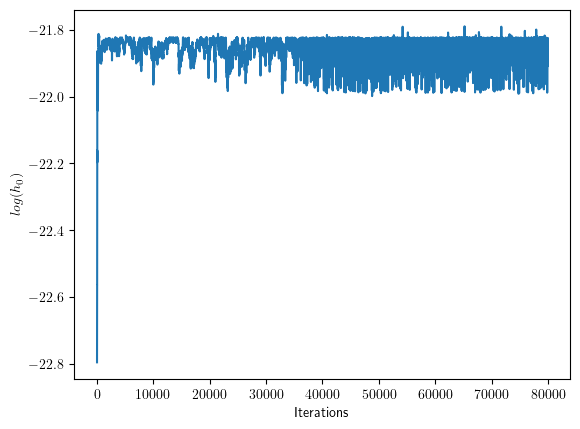

In [59]:
plt.figure(0)
plt.plot(chains[0, 0, :, 0])
#plt.show()
plt.ylabel(r'$log(h_0)$')
plt.xlabel('Iterations')
#plt.savefig('./bh_fig/11')

Text(0.5, 0, 'Iterations')

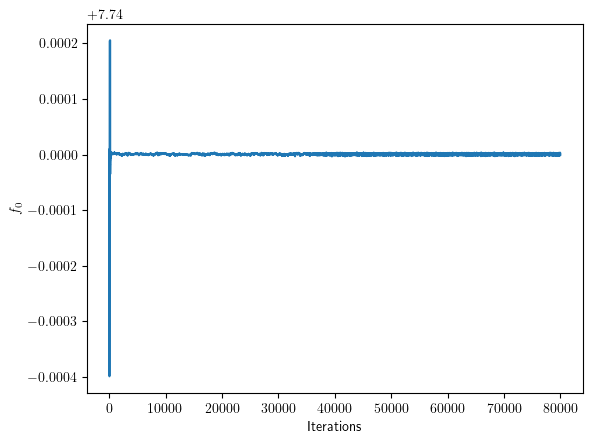

In [60]:
plt.plot(chains[0, 0, :, 1])
#plt.show()
plt.ylabel(r'$f_0$')
plt.xlabel('Iterations')
#plt.savefig('./bh_fig/12')

Text(0.5, 0, 'Iterations')

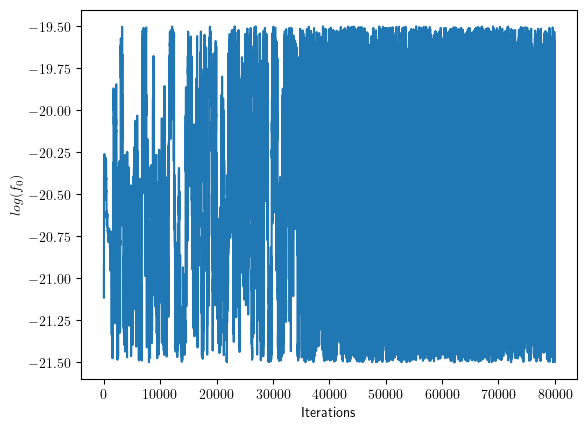

In [61]:
plt.plot(chains[0, 0, :, 2])
#plt.show()
plt.ylabel(r'$log(f_0)$')
plt.xlabel('Iterations')
#plt.savefig('./bh_fig/13')

Text(0.5, 0, 'Iterations')

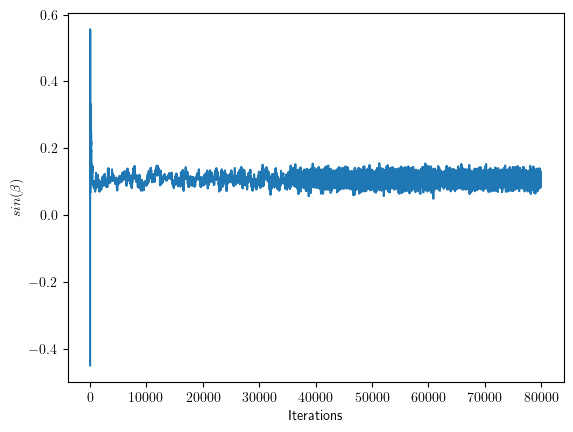

In [62]:
plt.plot(chains[0, 0, :, 3])
plt.ylabel(r'$sin(\beta)$')
plt.xlabel('Iterations')
#plt.savefig('./bh_fig/14')

Text(0.5, 0, 'Iterations')

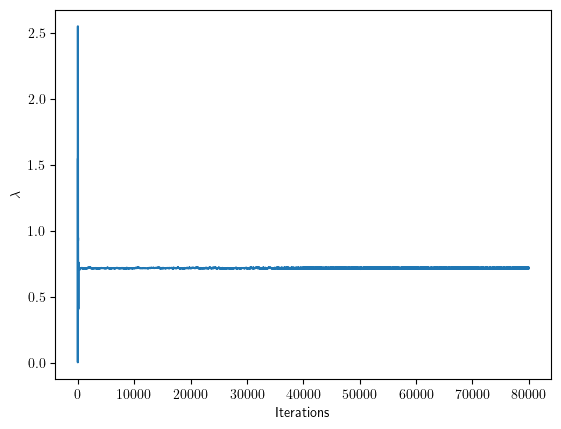

In [63]:
plt.plot(chains[0, 0, :, 4])
plt.ylabel(r'$\lambda$')
plt.xlabel('Iterations')
#plt.savefig('./bh_fig/15')

In [17]:
burnin =79500
samples_plot = chains[0, :, burnin:, :].reshape((nwalkers*(chains.shape[2]-burnin),chains.shape[-1]))

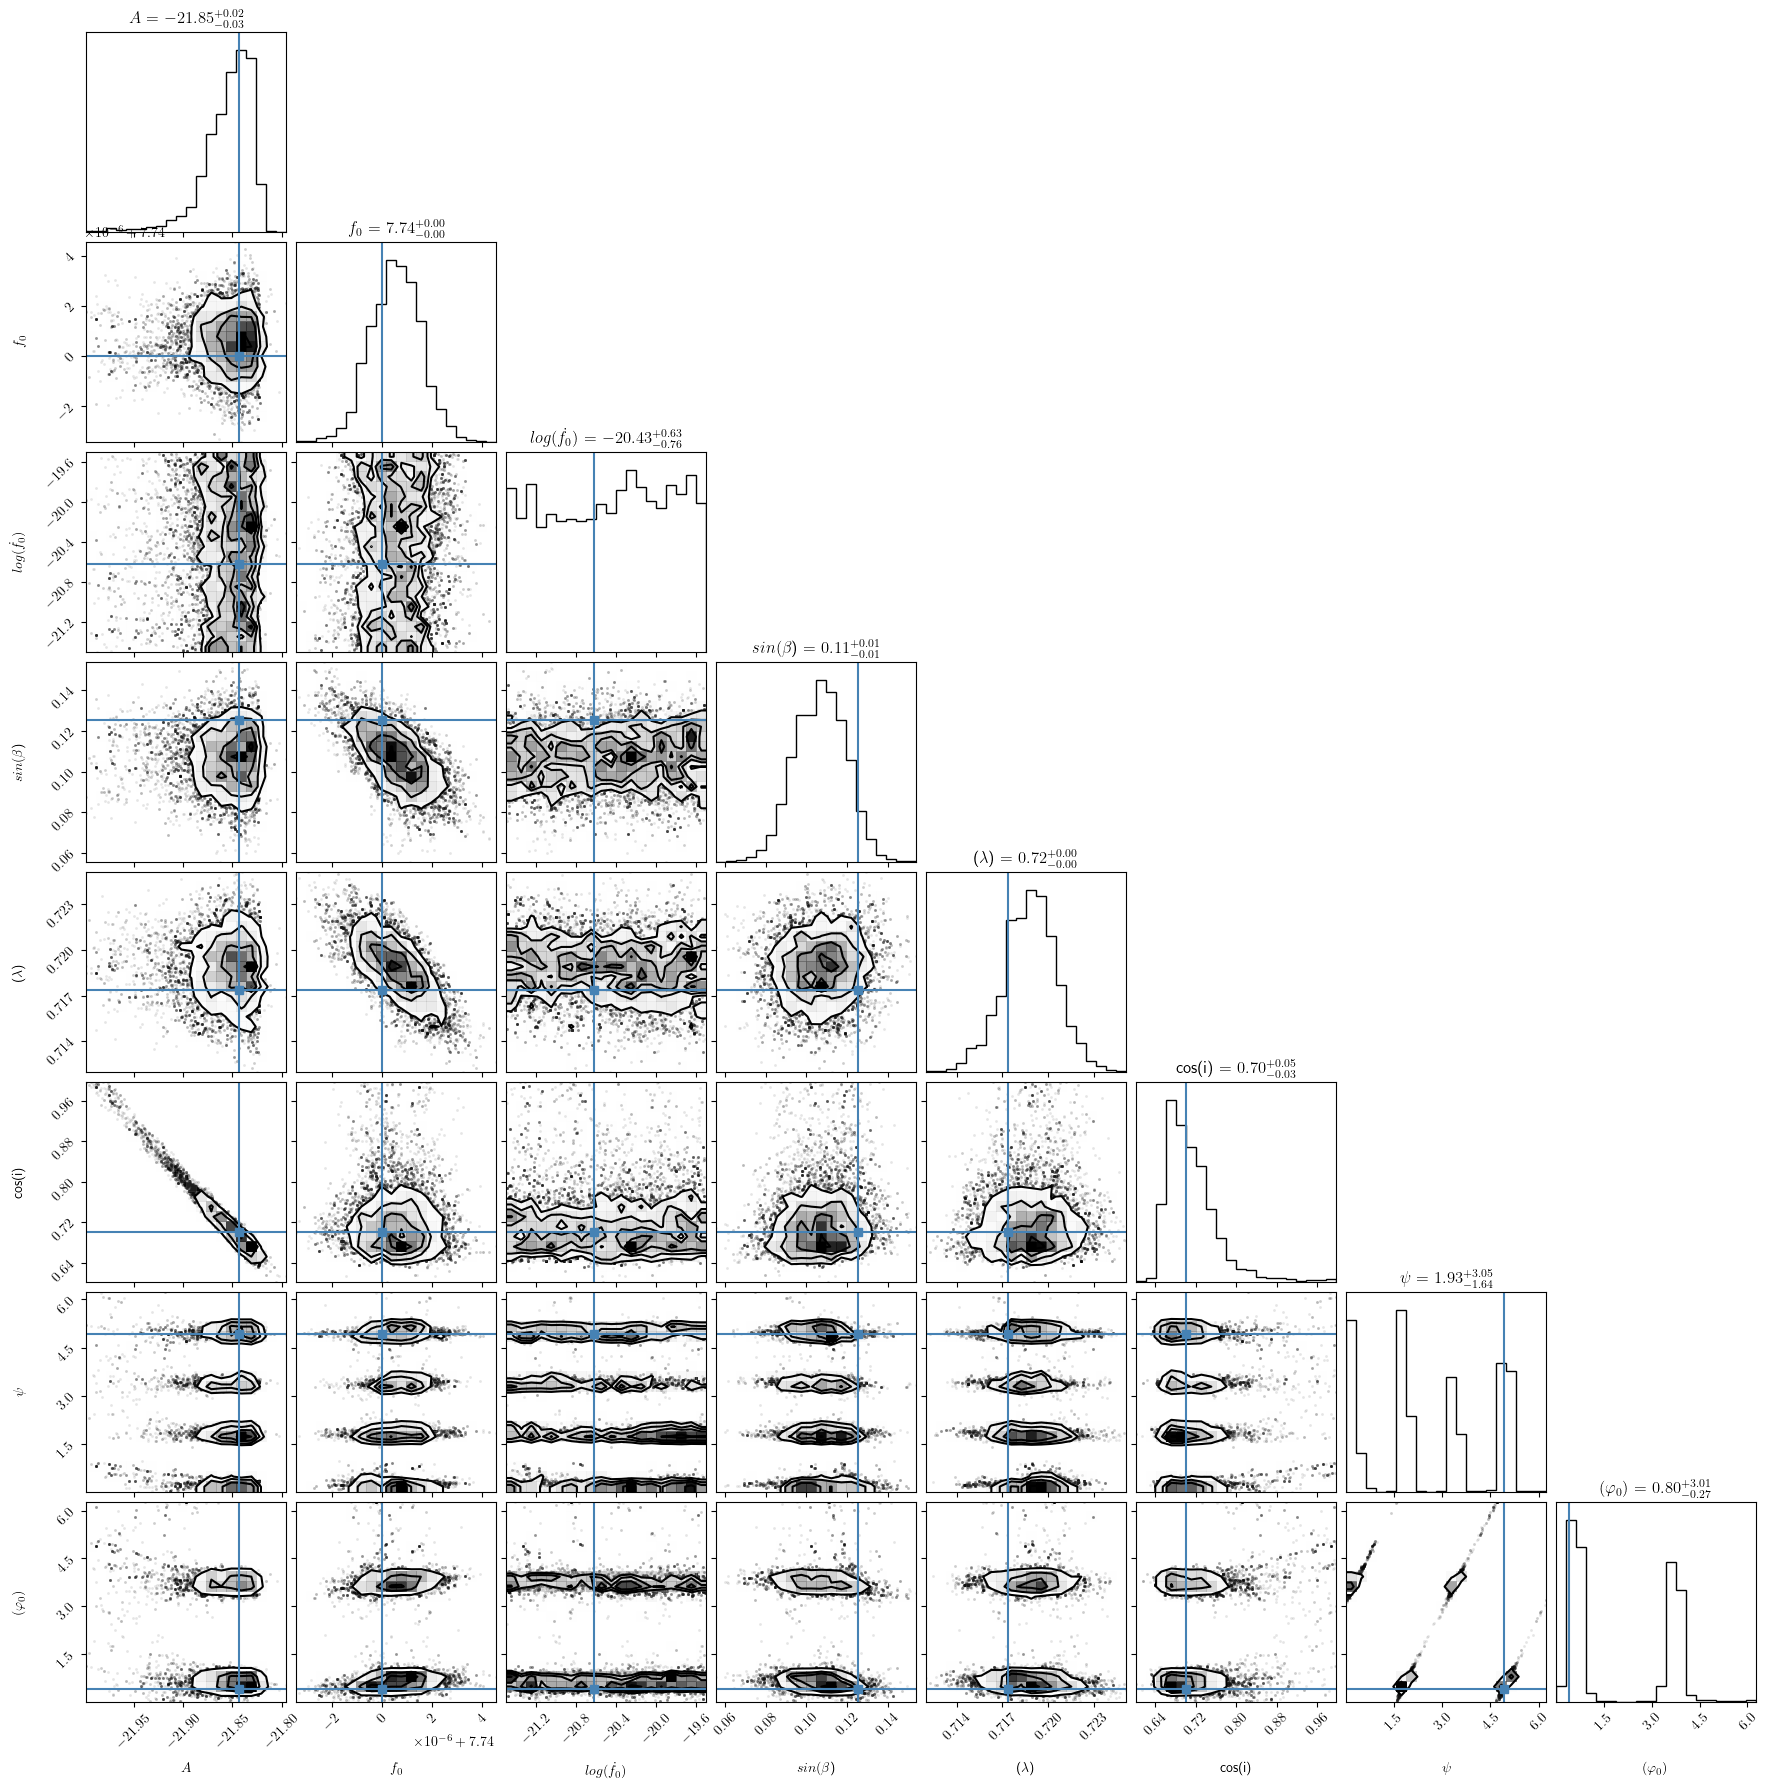

In [18]:
plt.rcParams['text.usetex']=True
import corner
figure = corner.corner(samples_plot, labels=["$A$", "$f_0$", "$log(\dot{f}_0)$",r"$sin(\beta$)",r"($\lambda$)",r"cos(i)",
                                        r"$\psi$",r"$(\varphi_0)$"],
                      truths=[p_sample_true[0], p_sample_true[1], p_sample_true[2],p_sample_true[3],p_sample_true[4],p_sample_true[5],p_sample_true[6],p_sample_true[7]],
                        # quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12})

plt.savefig('cornerplotucb1608.png')

In [31]:
#BH priors
from scipy.special import gamma

c = 299792458.0
Phi_s=10**(-3)
logMass_s=8.4
M_star=10**logMass_s
a_c=-1.19
beta2=0.5116394637708428
alpha_moy=0.12
alpha=alpha_moy
chi=0.5

def Dist_BH(M,d):
    return ((1/(d+1))**(beta2)*Phi_s*(M/M_star)**(1+a_c)*np.exp(1-(M/M_star)))

def P_M(M):
    return (Phi_s*(M/(M_star))**(1+a_c)*np.exp(1-(M/M_star)))

#Amplitudeh_0
m=1
def chi_f(alpha_f):
    return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def dist_z(z):
    #return Phi_s*(M_star/z)**(2-beta2)*np.exp(1)*gamma(a-beta2+3)
    return (1/(1+z)**beta2)


C1=float((8e-28/10)*(alpha/0.1)**7*(10**6)*((chi-0.45)/0.1))
C1_Mpc=float((8e-28/10)*(alpha/0.1)**7*((chi-0.45)/0.1))
H=float((2*c/70)*1e-3)

def P_d(x):
    return ((H*d1)**(beta2-1)/(x-d0+H*d1)**(beta2))

def logP_h0local(x):
    x=float(10**x)
    return -np.log(C1_Mpc)+np.log(Phi_s)+(1+a_c)*(np.log(x)-np.log(C1_Mpc*M_star))+(1-(x/C1_Mpc)/M_star)

def logP_h0Brito(x):
    x=10**x
    return np.log((1/C1_Mpc)*(0.005*((x/C1_Mpc)/3*10**6)**(0.3)))

#frequency
C2=(645*10*alpha_moy)/0.1
def logP_f0(x):
    x=float(x*1e-3)
    return 1+np.log(C2*Phi_s)+(1+a_c)*(np.log(C2/M_star)-np.log(x))-(2*np.log(x)+(C2/(x*M_star)))


#frequency derivative

C3=3e-14*10**2*(alpha/0.1)**19*chi**2
def logP_f0dot(x):
    x=float(10**x) 
    return 1+np.log(Phi_s/2)+(1+a_c/2)*np.log(C3)-(1+a_c)*np.log(M_star)-(2+a_c/2)*np.log(x)-np.sqrt(C3/x)/M_star

In [32]:
def logprior_set3(theta,a,b):
    logh0,f,logfdot,sinbeta,lamb,cos_i,pol,ph=theta
    if (np.all(a <=theta) and np.all(b >= theta)):
        
        p=logP_h0local(logh0)+logP_f0(f)+logP_f0dot(logfdot)
    
    else :
        p=-np.inf
    #print(logP_h0local(logh0))
    #print(logP_f0(f))
    #print(logP_f0dot(logfdot))
    return p
           

In [35]:
from multiprocessing import Pool
import os
import time
#Needs to disable numpy internal multithreading 
# # as it does not get along well with multiprocessing
os.environ["OMP_NUM_THREADS"] = "1"
# # pool = None
ndim = len(p_sample_true)
nwalkers = 8 * ndim
ntemps = 20

# Intialize the parameter state
pos = np.random.uniform(low=a,high=b,size=(ntemps, nwalkers, ndim))

# Number of iterations
n_iter = 5000
n_thin = 1
# Save results every 100 samples
n_save = 100
# Print progress every 200 samples
n_verbose = 200
# Initialize iteration counter
i = 0
isave = 0

output_dir = "./"
chain_suffix = "mychains1608smbh.h5"
# logl_suffix = "mylogl.h5"
# logp_suffix = "mylogp.h5"

hdf5 = HDF5Store(output_dir + chain_suffix, 
                 "chains", 
                 np.shape(pos), 
                 dtype=float, 
                 compression="gzip", 
                 chunk_len=1)

# Block of chain to be saved
nsize = np.min([n_save, n_iter])
chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
logl_save = np.zeros((ntemps, nwalkers, nsize))
logp_save = np.zeros((ntemps, nwalkers, nsize))
t1 = time.time()


with Pool(8) as pool:
    sampler = ptemcee.Sampler(nwalkers, ndim, loglike, logprior_set3, 
                              logpargs=[a,b],loglargs=[], 
                              ntemps=int(ntemps),
                              pool=pool)
    for pstate, lnlike0, lnprob0 in sampler.sample(pos, n_iter, thin=n_thin, storechain=True):
    
        # Store data
        chain_save[:, :, isave, :] = pstate
        logl_save[:, :, isave] = lnlike0
        logp_save[:, :, isave] = lnprob0

        if isave == n_save - 1:
            # If the number of iterations in a multiple of n_save
            print("Save data at iteration " + str(i) + "...")
            # The number of saved iterations at iteration i is
            # saved_it = i // thin
            # ------Samples---------

            hdf5.append(hdf5.chain_to_save(chain_save))
            # ------Log likelihood---------
            # ------Log prior---------
            print("Data saved.")
            # Update the number of samples saved
            isave += nsize
            # Once data is saved, re-initialize the arrays
            nsize = np.min([n_save, n_iter-i])
            chain_save = np.zeros((ntemps, nwalkers, nsize, ndim))
            logl_save = np.zeros((ntemps, nwalkers, nsize))
            logp_save = np.zeros((ntemps, nwalkers, nsize))
            # Set the saving counter to zero
            isave = 0
        else:
            # increment saving counter
            isave += 1
    
        if i % (n_verbose -1) == 0:
            print("Iteration " + str(i) + " completed.")
        # Increment global counter
        i += 1


t2 = time.time()

Iteration 0 completed.
Save data at iteration 99...
Data saved.
Save data at iteration 199...
Data saved.
Iteration 199 completed.
Save data at iteration 299...
Data saved.
Iteration 398 completed.
Save data at iteration 399...
Data saved.
Save data at iteration 499...
Data saved.
Iteration 597 completed.
Save data at iteration 599...
Data saved.
Save data at iteration 699...
Data saved.
Iteration 796 completed.
Save data at iteration 799...
Data saved.
Save data at iteration 899...
Data saved.
Iteration 995 completed.
Save data at iteration 999...
Data saved.
Save data at iteration 1099...
Data saved.
Iteration 1194 completed.
Save data at iteration 1199...
Data saved.
Save data at iteration 1299...
Data saved.
Iteration 1393 completed.
Save data at iteration 1399...
Data saved.
Save data at iteration 1499...
Data saved.
Iteration 1592 completed.
Save data at iteration 1599...
Data saved.
Save data at iteration 1699...
Data saved.
Iteration 1791 completed.
Save data at iteration 1799.

In [36]:
chains_bh = hdf5.save_to_chain(hdf5.load())

In [38]:
burnin =4500
samples_plot_bh = chains_bh[0, :, burnin:, :].reshape((nwalkers*(chains_bh.shape[2]-burnin),chains_bh.shape[-1]))

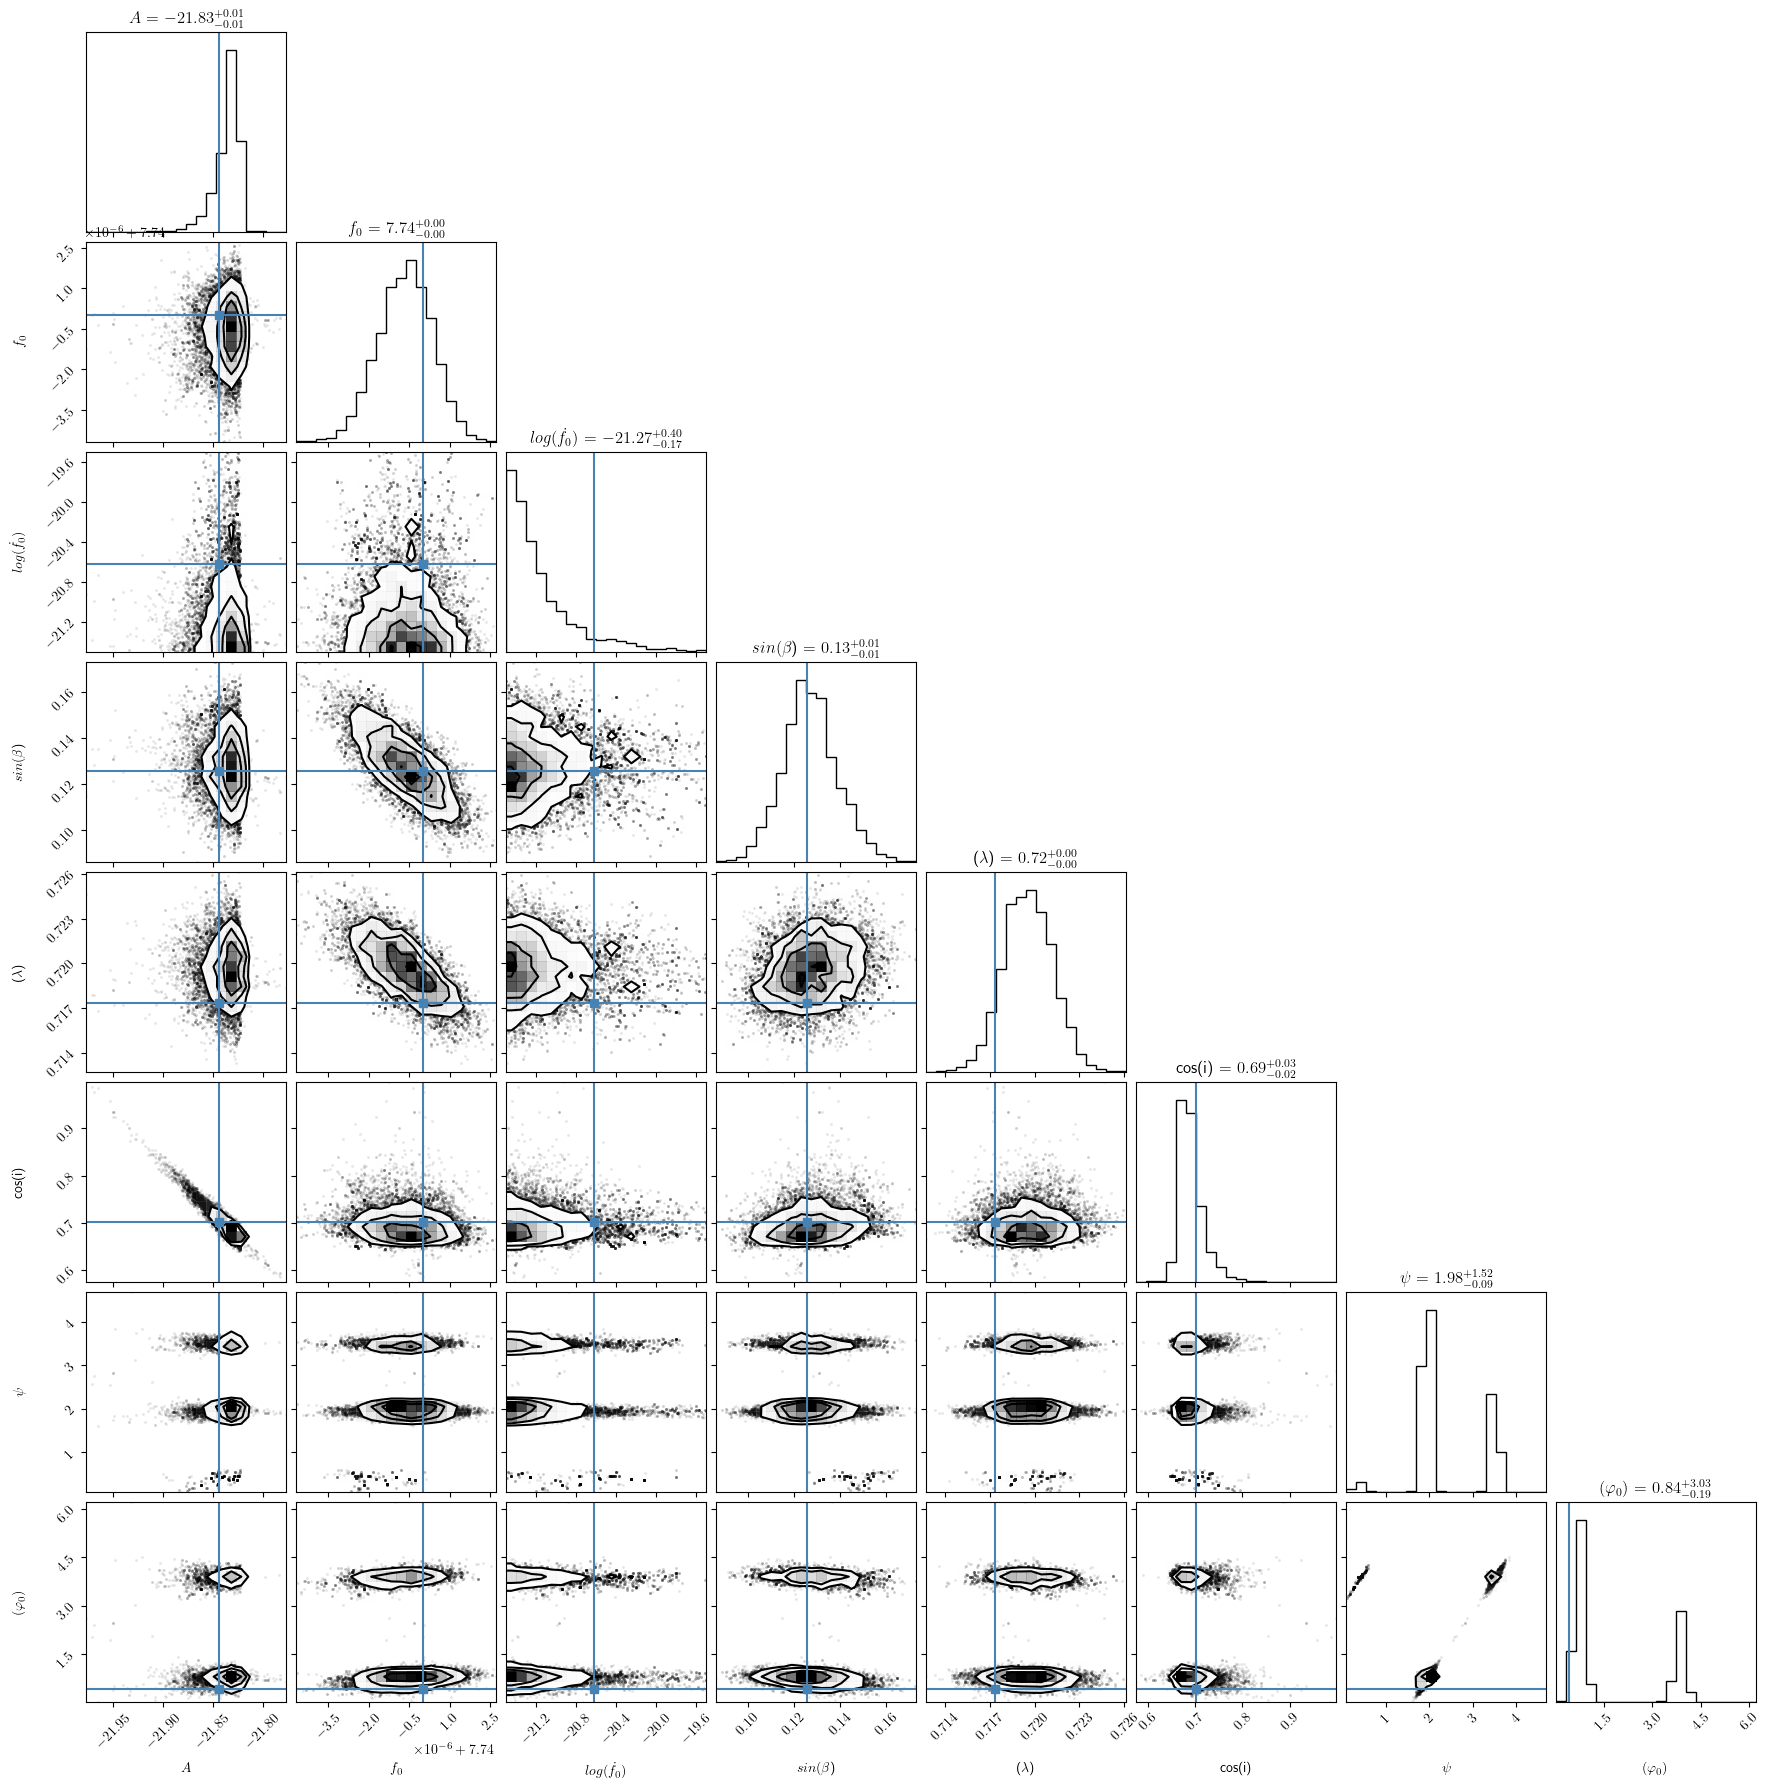

In [41]:
plt.rcParams['text.usetex']=True
figure = corner.corner(samples_plot_bh, labels=["$A$", "$f_0$", "$log(\dot{f}_0)$",r"$sin(\beta$)",r"($\lambda$)",r"cos(i)",
                                        r"$\psi$",r"$(\varphi_0)$"],
                      truths=[p_sample_true[0], p_sample_true[1], p_sample_true[2],p_sample_true[3],p_sample_true[4],p_sample_true[5],p_sample_true[6],p_sample_true[7]],
                        # quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12})

plt.savefig('cornerplot1608bh500.png')

In [40]:
#logEvidence calculation
log_model, uncertainty = sampler.log_evidence_estimate(fburnin=0.9)
print("Estimated log evidence for SMBH model (500) = ", log_model, "+/-", uncertainty)
#log_model_1, uncertainty = sampler.log_evidence_estimate(fburnin=0.95)
#print("Estimated log evidence for SMBH model (1000) = ", log_model_1, "+/-", uncertainty)
log_model_full, uncertainty = sampler.log_evidence_estimate(fburnin=0.1)
print("Estimated log evidence for SMBH model (full) = ", log_model_full, "+/-", uncertainty)

Estimated log evidence for SMBH model (500) =  5219.803353282517 +/- 3.306973957623086
Estimated log evidence for SMBH model (full) =  4910.966957255854 +/- 138.33211973878224
